##Importing and installing need libraries

In [6]:
import numpy as np
from tensorflow.keras import Model as Model_
from tensorflow.keras.layers import Input, ReLU, LSTM, Dense, TimeDistributed, Bidirectional, Normalization, GaussianNoise 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential, model_from_json
import tensorflow as tf
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from itertools import chain

print(tf.keras.__version__)

2.8.0


In [2]:
#Need only to be used with google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install tensorflow_model_remediation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 142 kB 4.8 MB/s 


In [4]:
import tensorflow_model_remediation.min_diff.losses.mmd_loss as MMD
import tensorflow_model_remediation.min_diff.losses.adjusted_mmd_loss as adjustedMMD

##Dataset reading

In [5]:
#Was done in the preprocessing in [1]
# Joints in H3.6M -- data has 32 joints, but only 17 that move; these are the indices.
H36M_NAMES = ['']*32
H36M_NAMES[0]  = 'Hip'
H36M_NAMES[1]  = 'RHip'
H36M_NAMES[2]  = 'RKnee'
H36M_NAMES[3]  = 'RFoot'
H36M_NAMES[6]  = 'LHip'
H36M_NAMES[7]  = 'LKnee'
H36M_NAMES[8]  = 'LFoot'
H36M_NAMES[12] = 'Spine'
H36M_NAMES[13] = 'Thorax'
H36M_NAMES[14] = 'Neck/Nose'
H36M_NAMES[15] = 'Head'
H36M_NAMES[17] = 'LShoulder'
H36M_NAMES[18] = 'LElbow'
H36M_NAMES[19] = 'LWrist'
H36M_NAMES[25] = 'RShoulder'
H36M_NAMES[26] = 'RElbow'
H36M_NAMES[27] = 'RWrist'

In [7]:
import os
import re

class Dataset_Preprocessing:
    def __init__(self, dir_path, include_dimension = 2, sample_size = 50,
                 total_classes = 17, datatype = 'float32', include_movable_joints = False):
        
        #Dataset Directory path
        self.dir_path = dir_path
        
        #Which Dimension file to include, possible values: 2 and 3
        self.include_dimension = include_dimension
        
        #Total frames in one Sample
        self.sample_size = sample_size
        
        #Default Datatype for all the samples
        self.datatype = datatype
        
        #Activity classes to include
        self.classes = ['SittingDown', 'Walking', 'Directions', 'Discussion', 'Sitting', 'Phoning', 'Eating', 'Posing', 'Greeting', 'Smoking']
        
        #Total activity classes
        self.total_classes = len(self.classes)
        
        #Subject Folders names in the Dataset
        self.internal_folders = ['S1', 'S5','S6','S7','S8','S9','S11']

        #Boolean value indicating whether to include all joints or only the movable joints.
        self.include_movable_joints = include_movable_joints
        
        self.movable_joints = [0, 1, 2, 3, 6, 7, 8, 12, 13, 14, 15, 17, 18, 19, 25, 26, 27]
    
    def read_dataset(self):
        try:
            #Contains all the different activity vectors
            activity_vector = {}
            
            #Contains the overall dataset
            sampled_data = None
            
            #Based on dimensions, which folder to use for extracting the dataset files
            data_folder = 'Poses_D2_Positions' if self.include_dimension == 2 else 'Poses_D3_Positions'
            
            #Checking if the dataset path is valid
            if not os.path.exists(self.dir_path):
                print('The Data Directory Does not Exist!')
                return None

            #Iterating over all the subject folders
            for fld in self.internal_folders:
                #Iterating for each file in the specified folder
                for file in os.listdir(os.path.join(self.dir_path, fld, data_folder)):
                    #Extracting the activity from the filename
                    activity = self.__extract_activity(file)
                    
                    if activity not in self.classes:
                        continue
                    
                    #Reading the CSV file using Pandas
                    data = pd.read_csv(os.path.join(self.dir_path, fld, data_folder, file), header=None)

                    #Formulating the activity vector using one hot encoding
                    if activity not in activity_vector:
                        total_keys = len(activity_vector.keys())
                        activity_vector[activity] = np.zeros(self.total_classes)
                        activity_vector[activity][total_keys] = 1
                    vector = activity_vector[activity]
                    
                    #Sampling the dataset
                    grouped_sample = self.__group_samples(data, self.sample_size, vector)
                    sampled_data = grouped_sample if sampled_data is None else np.append(sampled_data, grouped_sample, axis=0)
            
            #Changing the Datatype
            sampled_data = sampled_data.astype(self.datatype)
            
            return sampled_data
        except Exception as e:
            print(e)
    
    def __extract_activity(self, filename):
        try:
            #Extracting the filename and excluding the extension
            name = os.path.splitext(filename)[0]
            
            #Substituting the empty string with characters other than english alphabets
            activity = re.sub('[^A-Za-z]+' , '' , name)
            return activity
        except Exception as e:
            print(e)
    
    def __group_samples(self, dataset, sample_size, activity):
        try:
            #Checking if the dataset is a Pandas Dataframe
            if not isinstance(dataset, pd.DataFrame):
                print('Expecting Pandas Dataframe, but got {}'.format(type(dataset)))
                return None
            
            if self.include_movable_joints:
                joints = list(chain.from_iterable((jt*2, (jt*2)+1) for jt in self.movable_joints))
                dataset = dataset.iloc[: , joints].copy()

            #Appending activity class to each row in the dataset
            dataset = pd.concat([dataset, pd.DataFrame(np.tile(activity, (dataset.shape[0],1)))], axis=1)
            
            #Reshaping the dataset into sample batches
            total_samples = dataset.shape[0]//sample_size
            total_features = dataset.shape[1]
            grouped_rows = dataset.to_numpy()[:total_samples*self.sample_size].reshape((-1,self.sample_size, total_features))
            
            return grouped_rows
        except Exception as e:
            print(e)

In [35]:
#For long term prediction, we need a sample size of 60(10 frames input sequance, 50 frames predicted sequance)
sampled_data = Dataset_Preprocessing('/content/drive/MyDrive/Colab Notebooks/H3.6csv', sample_size=60, include_movable_joints=True).read_dataset()

In [42]:
def split_to_features_labels(dataset, input_sequance_size=10, total_features=64) :
    """
    Function for splitting the data into features(with sequance size=iput_sequance_size)
    and labels which should be the remainder of the sample length 
    """
    assert input_sequance_size < dataset.shape[1], f"input sequance should be smaller than the total sample size"
    features = dataset[:, np.s_[0:input_sequance_size], :]
    labels = dataset[:,np.s_[input_sequance_size:], :total_features]
    
    return features, labels

In [37]:
#To make the data divisible for batch size of 20
total_batches = sampled_data.shape[0]
sampled_data = sampled_data[:total_batches-(total_batches%20)]

In [43]:
sampled_dataX, sampled_dataY = split_to_features_labels(sampled_data, input_sequance_size=10, total_features=34)

In [45]:
print('Total Samples: {}'.format(sampled_dataY.shape[0]))
print('Total Frames: {}'.format(sampled_dataY.shape[1]))
print('Total Features: {}'.format(sampled_dataY.shape[2]))

Total Samples: 25520
Total Frames: 50
Total Features: 34


##Adding Preprocessing steps to improve model performance and robustness

### downsampling the dataset number of frames

In [46]:
def downsampling(sampled_data, downsample_technique = 'skip'):
    """
    The function used to down-sample the data using two different techniques. In Skip, one frame is skipped consecutively and
    in the mean technique, two frames are averaged consecutively.
    """
    samples_per_batch = int(sampled_data.shape[1] / 2)
    total_features = sampled_data.shape[2]
    downsampled_data = np.empty(shape=(0, samples_per_batch, total_features))
    
    if downsample_technique == 'skip':
        downsampled_data = sampled_data[:,::2,:]
    else:
        for batch in sampled_data:
            averaged_batch = np.empty(shape=(0, total_features))
            for i in range(0, batch.shape[0], 2):
                averaged_batch = np.append(averaged_batch, np.mean(batch[i:i+2, :], axis = 0).reshape((1, total_features)), axis = 0)
            downsampled_data = np.append(downsampled_data, averaged_batch.reshape((1, samples_per_batch, total_features)), axis = 0)
    return downsampled_data

### Adding more preprocessing steps (Normalization and gussian noise)

In [47]:
def preprocess_data(sampled_dataX, sampled_dataY, normalize=True, add_noise=True
                    , stddev=0.05) :
    """
    Function to preprocess data by normalizing input features and adding guassian
    noise to increase model robustness
    """  
    if normalize :
      sampled_dataX =  tf.keras.utils.normalize(sampled_dataX, axis=2)
    if add_noise :
      guassian_noise_layer = tf.keras.layers.GaussianNoise(stddev=stddev)
      sampled_dataX = guassian_noise_layer(sampled_dataX)
    return sampled_dataX, sampled_dataY

In [48]:
preprocessed_sampled_dataX, preprocessed_sampled_dataY = preprocess_data(sampled_dataX, sampled_dataY) 

In [49]:
downsampled_data = downsampling(sampled_data, 'skip')

In [52]:
downsampled_dataX, downsampled_dataY = split_to_features_labels(downsampled_data, input_sequance_size=10, total_features=34)
preprocessed_downsampled_dataX, preprocessed_downsampled_dataY = preprocess_data(downsampled_dataX, downsampled_dataY) 

##Defining different components of the model

In [20]:
class InterpolationLayer(tf.keras.layers.Layer):
    """
    Custom interpolation layer extending the keras layer class
    it has one attribute num_frames to be interpolated between each two consecutive 
    timesteps
    it has one main function interpolateFrames  
    """
  
    def __init__(self, num_frames=5):
        super(InterpolationLayer, self).__init__()
        self.num_frames = num_frames
       
    def interpolateFrames(self, inputs):
      """
      Takes input tensors of shape(batch_size, timesteps, features)
      returns interpolated frames with shape(batch_size, timesteps*num_frames, features)
      """
      batch_size = inputs.shape[0]
      timesteps = inputs.shape[1]
      features = inputs.shape[2]
      interpolated_frames = tf.zeros([0, features])

      for batch in tf.range(tf.shape(inputs)[0]) :
        tf.autograph.experimental.set_loop_options(
        shape_invariants=[(interpolated_frames, tf.TensorShape([None, features]))])
        for t in range(timesteps) :
          for j in range(self.num_frames) :
            X_i0 = inputs[batch, t]
            if(t == timesteps-1) :
              X_i1 = inputs[batch, t]
            else :  
              X_i1 = inputs[batch, t+1]
            alpha_j = j/self.num_frames
            current_frame = alpha_j*X_i0 + (1-alpha_j)*X_i1
            current_frame = tf.reshape(current_frame, [1, features])
            interpolated_frames = tf.concat((interpolated_frames, current_frame), axis=0)
      interpolated_frames = tf.reshape(interpolated_frames,[
          tf.shape(inputs)[0], (timesteps)*self.num_frames, features])
      return interpolated_frames

    def call(self, inputs):
      return self.interpolateFrames(inputs)

### Trying to create a keras glocalNet model through a custom function

In [21]:
def create_glocalNet_model(enocder_hidden_state=200, decoder_hidden_state=200, 
                 output_diminsion=64, input_diminsions=74, LSTM_dropout=0.25, dense_activation='relu',
                 interpolation_frames=5, exclude_locgen=False) :
    #Glogen encoder
    encoder_inputs = Input(shape=(10, input_diminsions))
    encoder = LSTM(enocder_hidden_state, return_sequences=True, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]
    #Glogen decoder
    decoder_lstm = LSTM(decoder_hidden_state, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(encoder_outputs,
                                        initial_state=encoder_states)
    decoder_dense = TimeDistributed(Dense(output_diminsion, activation=dense_activation))
    decoder_outputs = decoder_dense(decoder_outputs)

    #Interpolation layer
    interpolation_layer = InterpolationLayer(num_frames=interpolation_frames)
    interpolation_output = interpolation_layer(decoder_outputs)
    #return the model if execlude_locgen is true
    if(exclude_locgen) :
        return Model_(encoder_inputs, interpolation_output)
    
    #Locgen encoder
    encoder_locgen = LSTM(enocder_hidden_state, return_sequences=True, return_state=True)
    encoder_outputs_locgen, state_h_locgen, state_c_locgen = encoder_locgen(interpolation_output)
    encoder_states_locgen = [state_h_locgen, state_c_locgen]
    #Locgen decoder
    decoder_lstm_locgen = LSTM(decoder_hidden_state, return_sequences=True, return_state=True)
    decoder_outputs_locgen, _, _ = decoder_lstm(encoder_outputs_locgen,
                                        initial_state=encoder_states_locgen)
    decoder_dense_locgen = TimeDistributed(Dense(output_diminsion, activation=dense_activation))
    glocalNet_output = decoder_dense_locgen(decoder_outputs_locgen)
    return Model_(encoder_inputs, glocalNet_output)


### Custom glocalNet class

In [22]:
class GlocalNet(Model_):
    """
    A full GlocalNet implementation include the three main stages
    Glogen generating initial sparse frames
    Interpolation layer generating dense frames from Glogen output
    Locgen generating the final output by smoothing the interpolated frames
    """
    def __init__(self, enocder_hidden_state=200, decoder_hidden_state=200, 
                 output_diminsion=64, LSTM_dropout=0.25, dense_activation='relu',
                 interpolation_frames=5, exclude_locgen=False):
        super(GlocalNet, self).__init__()
        self.exclude_locgen = exclude_locgen
        #Glogen layers
        self.glogen_encoder = LSTM(enocder_hidden_state, return_state=True
                                   , return_sequences=True, dropout=LSTM_dropout)
        self.glogen_decoder = LSTM(decoder_hidden_state, return_sequences=True,
                                   return_state=True, dropout=LSTM_dropout)
        #Locgen layers
        self.locgen_encoder = LSTM(enocder_hidden_state, return_sequences=True,
                                   return_state=True, dropout=LSTM_dropout)
        self.locgen_decoder = LSTM(decoder_hidden_state, return_sequences=True,
                                   return_state=True, dropout=LSTM_dropout)
        #Glogen dense layer
        self.glogen_dense_layer = TimeDistributed(Dense(output_diminsion,
                                                        activation=dense_activation)) 
        #Interpolation layer
        self.interpolation_layer = InterpolationLayer(num_frames=interpolation_frames)
        #Locgen dense layer
        self.locgen_dense_layer = TimeDistributed(Dense(output_diminsion,
                                                        activation=dense_activation)) 
        
    def call(self, inputs):
        #Glogen calls      
        encoder_outputs, state_h, state_c = self.glogen_encoder(inputs)
        encoder_states = [state_h, state_c]
        output, _, _ = self.glogen_decoder(encoder_outputs, initial_state=encoder_states)
        glogen_output = self.glogen_dense_layer(output)

        #Interpolation call
        interpolated_frames = self.interpolation_layer(glogen_output)
        
        if self.exclude_locgen :
          return interpolated_frames

        #Locgen calls
        locgen_encoder_outputs, locgen_state_h, locgen_state_c = self.locgen_encoder(interpolated_frames)
        locgen_encoder_states = [locgen_state_h, locgen_state_c]
        locgen_output, _, _ = self.locgen_decoder(locgen_encoder_outputs, initial_state=locgen_encoder_states)
        final_output = self.locgen_dense_layer(locgen_output)
        return final_output

In [23]:
class JointLoss() :
    """
    Joint loss class with two weight attributes for two different losses
    first one is the loss joint and the second is the loss_motion_flow
    """
    def __init__(self, lambda1=0.5, lambda2=0.5, mmd_kernel='gaussian') :
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.mmd_kernel = mmd_kernel

    def loss_joint(self, predicted_sequance_batch, target_sequance_batch) :
        """
        Loss between the joint positions and its corresponding counterparts in the groundtruth
        """
        diff_norm_2 = tf.math.reduce_sum(tf.square(tf.subtract(predicted_sequance_batch, target_sequance_batch)), axis=2)
        return tf.reduce_sum(diff_norm_2, axis=1) 

    def loss_motion_flow(self, predicted_sequance_batch, target_sequance_batch) :
        """
        Loss between the motion flow of predicted sequance and the ground truth
        where the motion flow is the euclidean distance between each two consecutive frames
        """
        predictions_tomporal_diffs = tf.experimental.numpy.diff(predicted_sequance_batch, axis=1)
        real_tomporal_diffs = tf.experimental.numpy.diff(target_sequance_batch, axis=1)
        prediction_motion_flow_diff_norm_2 = tf.reduce_sum(tf.square(tf.subtract(predictions_tomporal_diffs, real_tomporal_diffs)), axis=2)
        return tf.reduce_sum(prediction_motion_flow_diff_norm_2, axis=1)


    def total_loss(self, target_sequance_batch, predicted_sequance_batch) :
        """
        calculating the total loss through a combination of the joint_loss and motion_flow_loss
        """
        joints_loss = self.loss_joint(predicted_sequance_batch, target_sequance_batch)
        motion_flow_loss = self.loss_motion_flow(predicted_sequance_batch, target_sequance_batch)
        return self.lambda1*joints_loss + self.lambda2*motion_flow_loss

    def custom_sequence_MMD_loss(self, target_sequance_batch, predicted_sequance_batch):
        """
        Calculating the Sequence MMD Loss between prediction and the ground Truth.
         Additionally combining the last two dimensions 
        """
        mmd_loss = MMD.MMDLoss(kernel=self.mmd_kernel)
        total_batches = predicted_sequance_batch.shape[0]
        frames_per_batch = predicted_sequance_batch.shape[1] * predicted_sequance_batch.shape[2]
        return mmd_loss(tf.reshape(predicted_sequance_batch, [total_batches, frames_per_batch]),
                        tf.reshape(target_sequance_batch, [total_batches, frames_per_batch]))

##Running experiment with different hyperparameters

In [27]:
def run_experiment(sampled_dataX, sampled_dataY, learning_rate=0.002, lambda1=0.5,
                   lambda2=0.5, use_mse=False, use_MMD=False, metrics=None, output_diminsion=64,
                   batch_size=100, epochs=50, validation_split=0.2, activation="relu",
                   dropout=0.25, exclude_locgen=False, interpolate_frames = 5) :
    """
    Method takes all hyperparameters as input paramters and returns the model and history as
    a result
    """
    glocal_model = GlocalNet(dense_activation=activation, LSTM_dropout=dropout,
                             exclude_locgen=exclude_locgen,
                             output_diminsion=output_diminsion, 
                             interpolation_frames = interpolate_frames)
    if use_mse :
        loss_function = tf.keras.losses.mean_squared_error
    elif use_MMD :
        loss_function = JointLoss().custom_sequence_MMD_loss
    else :
        loss_function = JointLoss(lambda1=lambda1, lambda2=lambda2).total_loss

    glocal_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                       loss=loss_function, metrics=metrics)
    history = glocal_model.fit(sampled_dataX, sampled_dataY,
                              batch_size=batch_size,
                              epochs=epochs, validation_split=validation_split)
    return history, glocal_model

In [25]:
def resume_training(glocal_model, sampled_dataX, sampled_dataY, learning_rate=0.002, lambda1=0.5,
                   lambda2=0.5, use_mse=False, use_MMD=False, metrics=None,
                   batch_size=100, epochs=50, validation_split=0.2) :
    """
    function to resume training of a model
    """
    if use_mse :
      loss_function = tf.keras.losses.mean_squared_error
    elif use_MMD :
      loss_function = JointLoss().custom_sequence_MMD_loss
    else :
      loss_function = JointLoss(lambda1=lambda1, lambda2=lambda2).total_loss

    glocal_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss=loss_function, metrics=metrics)
    history = glocal_model.fit(sampled_dataX, sampled_dataY,
                            batch_size=batch_size,
                            epochs=epochs, validation_split=validation_split)
    return history, glocal_model

## Experiment Running for MSE and joint loss

In [ ]:
history_mse, glocal_model_mse = run_experiment(sampled_dataX, sampled_dataY, epochs=10, batch_size=50, use_mse=True, metrics=[tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/10
409/409 [==============================] - 311s 720ms/step - loss: 177825.9844 - mean_absolute_percentage_error: 82.8186 - val_loss: 124027.8594 - val_mean_absolute_percentage_error: 66.8344
Epoch 2/10
409/409 [==============================] - 293s 716ms/step - loss: 90484.2344 - mean_absolute_percentage_error: 54.1147 - val_loss: 62696.0195 - val_mean_absolute_percentage_error: 42.4023
Epoch 3/10
409/409 [==============================] - 293s 716ms/step - loss: 46615.4414 - mean_absolute_percentage_error: 35.0630 - val_loss: 34037.5977 - val_mean_absolute_percentage_error: 28.6017
Epoch 4/10
409/409 [==============================] - 292s 713ms/step - loss: 27399.0527 - mean_absolute_percentage_error: 25.4459 - val_loss: 22726.5059 - val_mean_absolute_percentage_error: 22.9845
Epoch 5/10
409/409 [==============================] - 290s 709ms/step - loss: 20389.1250 - mean_absolute_percentage_error: 21.9130 - val_loss: 19172.2676 - val_mean_absolute_percentage_error: 21.536

In [ ]:
 history_jointLoss, glocal_model_jointLoss = run_experiment(epochs=10, lambda1=0.5, lambda2=0.5, metrics=[tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/10
255/255 [==============================] - 419s 248ms/step - loss: 318235136.0000 - mean_absolute_percentage_error: 88.8408
Epoch 2/10
255/255 [==============================] - 63s 248ms/step - loss: 209204064.0000 - mean_absolute_percentage_error: 68.7124
Epoch 3/10
255/255 [==============================] - 64s 252ms/step - loss: 136290848.0000 - mean_absolute_percentage_error: 52.0030
Epoch 4/10
255/255 [==============================] - 63s 248ms/step - loss: 89421984.0000 - mean_absolute_percentage_error: 39.3298
Epoch 5/10
255/255 [==============================] - 64s 251ms/step - loss: 60899012.0000 - mean_absolute_percentage_error: 30.7696
Epoch 6/10
255/255 [==============================] - 65s 254ms/step - loss: 44627976.0000 - mean_absolute_percentage_error: 25.5873
Epoch 7/10
255/255 [==============================] - 64s 250ms/step - loss: 36028060.0000 - mean_absolute_percentage_error: 22.8682
Epoch 8/10
255/255 [==============================] - 64s 251ms/s

## Running experiment with MMD

In [ ]:
history_mmd, glocal_model_mmd = run_experiment(epochs=10, use_mse=True, metrics=[JointLoss().custom_sequence_MMD_loss,
                                                                                  tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/10
204/204 [==============================] - 495s 663ms/step - loss: 205974.6562 - custom_sequence_MMD_loss: 0.0100 - mean_absolute_percentage_error: 90.6578 - val_loss: 171432.6875 - val_custom_sequence_MMD_loss: 0.0100 - val_mean_absolute_percentage_error: 81.5120
Epoch 2/10
204/204 [==============================] - 56s 273ms/step - loss: 145359.6406 - custom_sequence_MMD_loss: 0.0100 - mean_absolute_percentage_error: 73.3579 - val_loss: 120135.9531 - val_custom_sequence_MMD_loss: 0.0100 - val_mean_absolute_percentage_error: 65.2601
Epoch 3/10
204/204 [==============================] - 55s 270ms/step - loss: 101290.3203 - custom_sequence_MMD_loss: 0.0100 - mean_absolute_percentage_error: 58.3517 - val_loss: 83172.4062 - val_custom_sequence_MMD_loss: 0.0100 - val_mean_absolute_percentage_error: 51.2563
Epoch 4/10
204/204 [==============================] - 55s 269ms/step - loss: 69855.6406 - custom_sequence_MMD_loss: 0.0100 - mean_absolute_percentage_error: 45.7777 - val_loss

In [ ]:
history_low_learning_rate, glocal_low_learning_rate = run_experiment(epochs=15, use_mse=True,learning_rate=0.0005,
                                                                     metrics=[JointLoss().custom_sequence_MMD_loss, 
                                                                              tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/15
204/204 [==============================] - 508s 688ms/step - loss: 232722.3750 - custom_sequence_MMD_loss: 0.0100 - mean_absolute_percentage_error: 97.5425 - val_loss: 222185.7188 - val_custom_sequence_MMD_loss: 0.0100 - val_mean_absolute_percentage_error: 95.1817
Epoch 2/15
204/204 [==============================] - 56s 275ms/step - loss: 214970.2344 - custom_sequence_MMD_loss: 0.0100 - mean_absolute_percentage_error: 93.0554 - val_loss: 205736.5312 - val_custom_sequence_MMD_loss: 0.0100 - val_mean_absolute_percentage_error: 90.8953
Epoch 3/15
204/204 [==============================] - 55s 271ms/step - loss: 199166.1562 - custom_sequence_MMD_loss: 0.0100 - mean_absolute_percentage_error: 88.8794 - val_loss: 190633.7812 - val_custom_sequence_MMD_loss: 0.0100 - val_mean_absolute_percentage_error: 86.7782
Epoch 4/15
204/204 [==============================] - 55s 272ms/step - loss: 184554.7031 - custom_sequence_MMD_loss: 0.0100 - mean_absolute_percentage_error: 84.8329 - val_lo

In [ ]:
#Running MMD with laplacian kernel
history_laplacian, glocal_model_laplacian = run_experiment(epochs=10, use_mse=True, metrics=[JointLoss(mmd_kernel="laplacian").custom_sequence_MMD_loss,
                                                                                   tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/10
255/255 [==============================] - 414s 249ms/step - loss: 197403.2812 - custom_sequence_MMD_loss: 0.0100 - mean_absolute_percentage_error: 88.3660
Epoch 2/10
255/255 [==============================] - 63s 248ms/step - loss: 127435.2109 - custom_sequence_MMD_loss: 0.0100 - mean_absolute_percentage_error: 67.5425
Epoch 3/10
255/255 [==============================] - 63s 248ms/step - loss: 80680.4375 - custom_sequence_MMD_loss: 0.0100 - mean_absolute_percentage_error: 50.2697
Epoch 4/10
255/255 [==============================] - 64s 250ms/step - loss: 50611.1797 - custom_sequence_MMD_loss: 0.0100 - mean_absolute_percentage_error: 37.2520
Epoch 5/10
255/255 [==============================] - 63s 249ms/step - loss: 32317.2383 - custom_sequence_MMD_loss: 0.0100 - mean_absolute_percentage_error: 28.5100
Epoch 6/10
255/255 [==============================] - 63s 247ms/step - loss: 21881.8242 - custom_sequence_MMD_loss: 0.0100 - mean_absolute_percentage_error: 23.2072
Epoch 7

##Running Experiment with preprocessing

In [ ]:
history_preprocessed, glocal_model_preprocessed = run_experiment(preprocessed_sampled_dataX, preprocessed_sampled_dataY,
                                                                 batch_size=20, dropout=0.0,
                                                                 epochs=50, use_mse=True, metrics=[JointLoss().custom_sequence_MMD_loss,
                                                                tf.keras.losses.mean_absolute_percentage_error], validation_split=0.0)

Epoch 1/50
1276/1276 [==============================] - 166s 72ms/step - loss: 103226.2188 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 55.7368
Epoch 2/50
1276/1276 [==============================] - 92s 72ms/step - loss: 24137.4199 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 22.3288
Epoch 3/50
1276/1276 [==============================] - 91s 71ms/step - loss: 20904.3418 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 21.1100
Epoch 4/50
1276/1276 [==============================] - 92s 72ms/step - loss: 20891.6875 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 21.1437
Epoch 5/50
1276/1276 [==============================] - 90s 71ms/step - loss: 20892.7051 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 21.1492
Epoch 6/50
1276/1276 [==============================] - 91s 72ms/step - loss: 20892.3887 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 21.1576
Ep

In [ ]:
history_interpolation_only, glocal_interpolation_only = run_experiment(preprocessed_sampled_dataX, preprocessed_sampled_dataY,
                                                                 batch_size=20, dropout=0.0, exclude_locgen=True,
                                                                 epochs=25, use_mse=True, metrics=[JointLoss().custom_sequence_MMD_loss,
                                                                tf.keras.losses.mean_absolute_percentage_error], validation_split=0.0)

Epoch 1/25
1276/1276 [==============================] - 132s 53ms/step - loss: 121033.2656 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 61.4075
Epoch 2/25
1276/1276 [==============================] - 68s 53ms/step - loss: 52719.6641 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 32.3998
Epoch 3/25
1276/1276 [==============================] - 68s 53ms/step - loss: 49959.7383 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 31.3550
Epoch 4/25
1276/1276 [==============================] - 67s 52ms/step - loss: 49949.2422 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 31.3862
Epoch 5/25
1276/1276 [==============================] - 66s 51ms/step - loss: 49950.2383 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 31.3838
Epoch 6/25
1276/1276 [==============================] - 64s 50ms/step - loss: 49949.6289 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 31.3861
Ep

## Running experiment with downsampling

In [ ]:
#Running experiment with downsampling
history_preprocessed, glocal_model_preprocessed = run_experiment(preprocessed_downsampled_dataX, preprocessed_downsampled_dataY,
                                                                 batch_size=20, dropout=0.0,
                                                                 epochs=50, use_mse=True, output_diminsion=34,
                                                                 metrics=[JointLoss().custom_sequence_MMD_loss,
                                                                          tf.keras.losses.mean_absolute_percentage_error], 
                                                                 validation_split=0.0, interpolate_frames = 2)

Epoch 1/50
1276/1276 [==============================] - 183s 131ms/step - loss: 101101.1641 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 55.7003
Epoch 2/50
1276/1276 [==============================] - 161s 126ms/step - loss: 25824.4961 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 22.9006
Epoch 3/50
1276/1276 [==============================] - 160s 125ms/step - loss: 22838.1289 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 21.7719
Epoch 4/50
1276/1276 [==============================] - 162s 127ms/step - loss: 22826.3379 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 21.8074
Epoch 5/50
1276/1276 [==============================] - 162s 127ms/step - loss: 22829.1035 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 21.8030
Epoch 6/50
1276/1276 [==============================] - 155s 121ms/step - loss: 22828.0098 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error:

In [ ]:
history_interpolation_only, glocal_interpolation_only = run_experiment(preprocessed_downsampled_dataX, preprocessed_downsampled_dataY,
                                                                       batch_size=20, dropout=0.0, exclude_locgen=True,
                                                                       epochs=30, use_mse=True, 
                                                                       metrics=[JointLoss().custom_sequence_MMD_loss,
                                                                                tf.keras.losses.mean_absolute_percentage_error], 
                                                                       validation_split=0.0, interpolate_frames = 2)

Epoch 1/30
1276/1276 [==============================] - 156s 110ms/step - loss: 107902.1328 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 57.0899
Epoch 2/30
1276/1276 [==============================] - 139s 109ms/step - loss: 31997.1133 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 24.8528
Epoch 3/30
1276/1276 [==============================] - 139s 109ms/step - loss: 28900.7832 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 23.6331
Epoch 4/30
1276/1276 [==============================] - 136s 107ms/step - loss: 28889.9883 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 23.6797
Epoch 5/30
1276/1276 [==============================] - 137s 107ms/step - loss: 28889.4648 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 23.6733
Epoch 6/30
1276/1276 [==============================] - 137s 108ms/step - loss: 28891.5488 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error:

In [ ]:
history_interpolation_only, glocal_interpolation_only= resume_training(glocal_interpolation_only,
                                                                                        preprocessed_downsampled_dataX,
                                                                                        preprocessed_downsampled_dataY,
                                                                                        epochs=20, metrics=[JointLoss().custom_sequence_MMD_loss,
                                                                tf.keras.losses.mean_absolute_percentage_error], use_mse=True,
                                                                                        validation_split=0.0, batch_size=20)

Epoch 1/20


OperatorNotAllowedInGraphError: ignored

## Trying to run models with function create model

In [ ]:
#Create model
glocal_model = create_glocalNet_model(interpolation_frames=2)

In [ ]:
history, glocal_model = resume_training(glocal_model, preprocessed_downsampled_dataX,
                                        preprocessed_downsampled_dataY, epochs=20, metrics=[JointLoss().custom_sequence_MMD_loss,
                                                                tf.keras.losses.mean_absolute_percentage_error], use_mse=True,
                                                                                        validation_split=0.0, batch_size=20)

Epoch 1/20
1276/1276 [==============================] - 148s 109ms/step - loss: 111516.4375 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 58.9935
Epoch 2/20
1276/1276 [==============================] - 140s 110ms/step - loss: 36232.0391 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 27.5385
Epoch 3/20
1276/1276 [==============================] - 140s 109ms/step - loss: 33126.2305 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 26.3246
Epoch 4/20
1276/1276 [==============================] - 140s 109ms/step - loss: 33114.9336 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 26.3629
Epoch 5/20
 824/1276 [==================>...........] - ETA: 49s - loss: 33054.0273 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 26.3581

KeyboardInterrupt: ignored

In [ ]:
#Create model
glocal_model_interpolation_only = create_glocalNet_model(interpolation_frames=2, exclude_locgen=True)

In [ ]:
history_interpolation_only, glocal_model_interpolation_only = resume_training(glocal_model_interpolation_only, preprocessed_downsampled_dataX,
                                        preprocessed_downsampled_dataY, epochs=10, metrics=[JointLoss().custom_sequence_MMD_loss,
                                                                tf.keras.losses.mean_absolute_percentage_error], use_mse=True,
                                                                                        validation_split=0.0, batch_size=20)

Epoch 1/10
1276/1276 [==============================] - 147s 109ms/step - loss: 112842.7109 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 58.6196
Epoch 2/10
1276/1276 [==============================] - 135s 106ms/step - loss: 39222.7109 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 27.4622
Epoch 3/10
1276/1276 [==============================] - 135s 105ms/step - loss: 36251.5234 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 26.3324
Epoch 4/10
1276/1276 [==============================] - 136s 107ms/step - loss: 36240.9648 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 26.3746
Epoch 5/10
1276/1276 [==============================] - 133s 105ms/step - loss: 36242.1094 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 26.3687
Epoch 6/10
1276/1276 [==============================] - 134s 105ms/step - loss: 36242.1484 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error:

In [ ]:
history_interpolation_only, glocal_model_interpolation_only = resume_training(glocal_model_interpolation_only, preprocessed_downsampled_dataX,
                                        preprocessed_downsampled_dataY, epochs=10, metrics=[JointLoss().custom_sequence_MMD_loss,
                                                                tf.keras.losses.mean_absolute_percentage_error], use_mse=True,
                                                                                        validation_split=0.0, batch_size=20)

Epoch 1/10
1276/1276 [==============================] - 137s 102ms/step - loss: 11911.0127 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 15.0896
Epoch 2/10
1276/1276 [==============================] - 130s 102ms/step - loss: 10850.7783 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 13.3697
Epoch 3/10
1276/1276 [==============================] - 130s 102ms/step - loss: 10477.5576 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 12.7002
Epoch 4/10
1276/1276 [==============================] - 131s 102ms/step - loss: 10315.3428 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 12.4256
Epoch 5/10
1276/1276 [==============================] - 130s 102ms/step - loss: 10149.4160 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 12.1875
Epoch 6/10
1276/1276 [==============================] - 128s 100ms/step - loss: 9894.6084 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 1

##Visualization

In [ ]:
def visualize_frames(sample, dynamic_joints_only=False,
                    num_frames_to_visualize=10,
                    joints_to_ignore=[4,5,9,10,11,16,20,21,22,23,24,28,29,30,31]) :
    """
    Visualization function to draw a certain number of frames in a given sample
    ignoring the joints mentioned in joints_to_ignore array
    """
    assert num_frames_to_visualize <= sample.shape[0], f"number of frames should be less than or equal to the total frames in the sample"
    fig, axs = plt.subplots(ncols=num_frames_to_visualize, figsize=(15, 8))
    fig.tight_layout(pad=1.0)
    for t in range(num_frames_to_visualize) :
        #Removing unnecessary joints for visualization
        if(dynamic_joints_only) :
            #Check if no joints needs to be removed
            truncated_frame = sample[t]
        else :
            #Removing the joints based on joints_to_ignore
            joints_to_ignore_2d = [element * 2 for element in joints_to_ignore]
            for i in range(len(joints_to_ignore_2d)) :
                joints_to_ignore_2d.append(joints_to_ignore_2d[i]+1)
            truncated_frame = np.delete(sample[t], joints_to_ignore_2d)   

        #In case of including only moving joints for Human3.6M(17 joints)      
        x_axis_array = truncated_frame[0:34:2]
        y_axis_array = truncated_frame[1:35:2]
        #Scattering all the 17 joints
        axs[t].scatter(x_axis_array, y_axis_array)
        #Plotting right leg
        axs[t].plot(x_axis_array[:4], y_axis_array[:4], "tab:blue")
        #plotting left leg
        axs[t].plot(x_axis_array[[0, 4, 5, 6]], y_axis_array[[0, 4, 5, 6]])
        #plotting from hip to head
        axs[t].plot(x_axis_array[[0, 7, 8, 9, 10]], y_axis_array[[0, 7, 8, 9, 10]])
        #plotting from neck to left shoulder
        axs[t].plot(x_axis_array[[9, 11, 12, 13]], y_axis_array[[9, 11, 12, 13]])
        #plotting from neck to right shoulder
        axs[t].plot(x_axis_array[[9, 14, 15, 16]], y_axis_array[[9, 14, 15, 16]])
        axs[t].invert_yaxis()
        axs[t].set_xticks([])
        axs[t].set_yticks([])
    plt.show()

In [ ]:
predictions = glocal_interpolation_only.predict(preprocessed_downsampled_dataX)

In [ ]:
predictions_glocal = glocal_model_preprocessed(preprocessed_downsampled_dataX[:1000])

In [ ]:
predictions.shape

TensorShape([1000, 20, 64])

In [ ]:
predictions[0, 0]

array([451.56577, 454.25308, 468.94785, 452.36102,   0.     , 529.5493 ,
       458.19006, 619.64685, 455.3011 , 624.9727 , 455.11966, 621.46906,
       433.17438, 456.40485, 423.32407, 532.86176, 427.82333, 624.4586 ,
       421.51144, 626.70905, 418.1145 , 621.7645 , 451.04324, 453.97513,
       452.57632, 400.5071 , 451.77573, 345.8369 , 450.3638 , 330.66556,
       452.86798, 308.32825, 451.6349 , 345.99356, 432.012  , 357.4587 ,
       410.84802, 408.78702, 412.2707 , 426.9592 , 411.9597 , 426.88635,
       415.99817, 418.14444, 408.7223 , 429.97964, 409.02606, 430.13068,
       451.5844 , 345.5225 , 470.71594, 359.75812, 485.21948, 411.1448 ,
       474.98096, 421.56848, 474.82556, 421.26617, 472.12268, 412.61395,
       473.70282, 422.007  , 473.85184,   0.     ], dtype=float32)

In [ ]:
predictions.shape

TensorShape([1000, 20, 64])

In [ ]:
predictions[150, 0:50:4].shape

TensorShape([5, 64])

In [ ]:
predictions[910, 0:20:2]

<tf.Tensor: shape=(10, 64), dtype=float32, numpy=
array([[599.934  , 433.4522 , 627.59155, 431.59116, 645.27075, 459.73172,
        634.62134, 540.52734, 639.5732 , 543.00146, 644.79333, 539.0089 ,
        572.60645, 435.27048, 584.0764 , 460.4823 , 600.1011 , 542.4445 ,
        601.933  , 543.0666 , 601.6524 , 538.21124, 599.85425, 433.48285,
        599.2806 , 385.38815, 601.2577 , 336.1908 , 605.55634, 322.19537,
        605.4941 , 301.56146, 601.2019 , 334.77145, 570.87537, 347.28848,
        548.77356, 403.64914, 567.3755 , 431.3358 , 567.3335 , 433.69504,
        574.5749 , 424.66946, 567.99445, 438.03885, 568.13434, 438.09763,
        601.2005 , 334.70712, 630.93317, 349.19455, 658.3205 , 407.58994,
        644.93713, 436.8463 , 644.9713 , 436.685  , 639.148  , 428.01227,
        648.3766 , 447.16125, 648.3258 , 447.20547],
       [604.8303 , 431.90866, 632.7451 , 430.15793, 650.146  , 458.371  ,
        639.11945, 537.2402 , 643.8425 , 539.4434 , 647.6748 , 535.19794,
        5

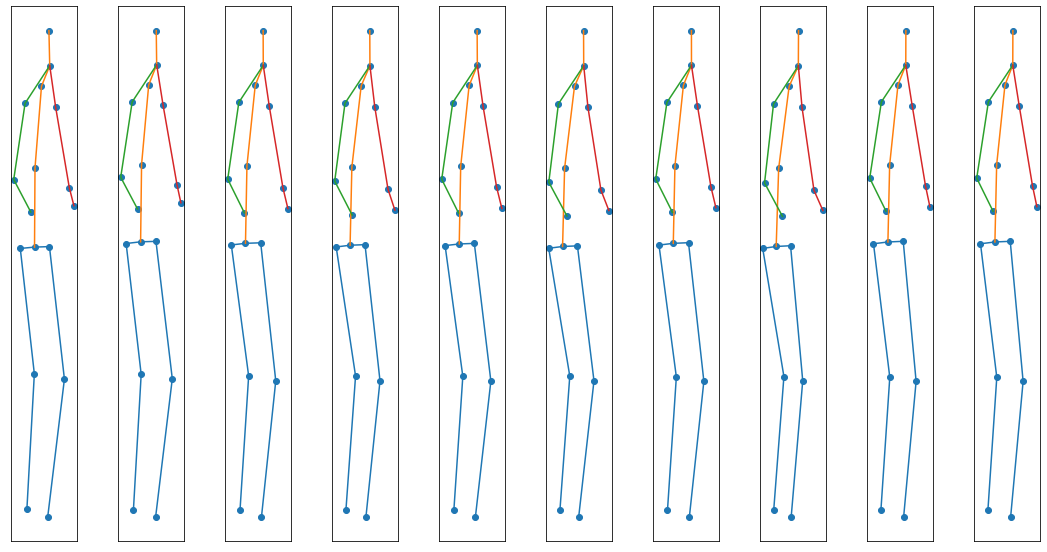

In [ ]:
visualize_frames(predictions[1300, 0:20:2], num_frames_to_visualize=10)

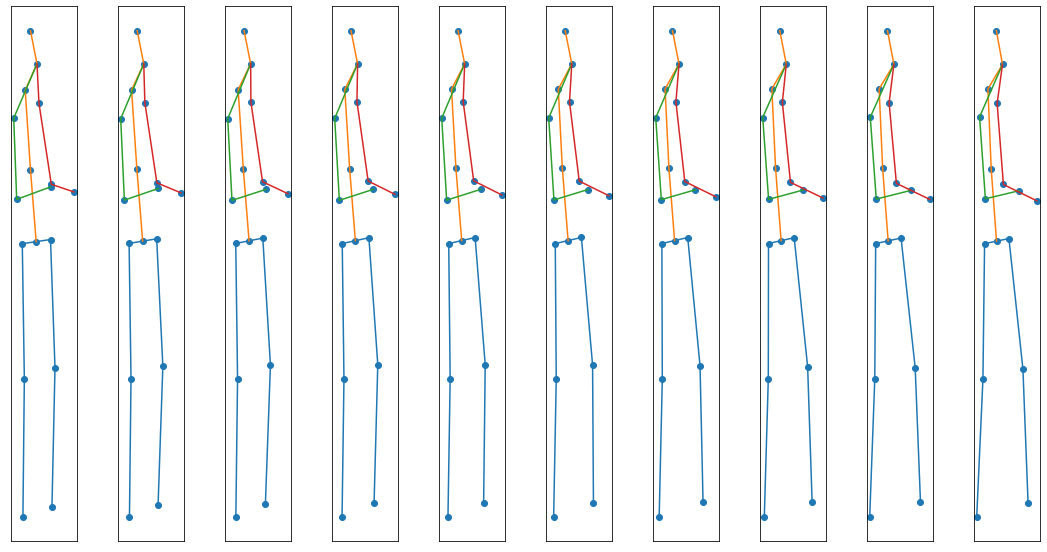

In [ ]:
visualize_frames(preprocessed_downsampled_dataX[1300], num_frames_to_visualize=10)

## Saving models

In [ ]:
glocal_interpolation_only.save('minterpolation_only_downsampled20',save_format='tf')

OperatorNotAllowedInGraphError: ignored

#References

[1] https://github.com/una-dinosauria/3d-pose-baseline/blob/master/src/data_utils.py